## Life expectancy vs obesity per country from 2000 to 2015
### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Read the data csv file
FILENAME = 'Life_Expectancy_00_15.csv'
data = pd.read_csv(FILENAME, delimiter=';')

# Remove Least Developed column, since it is not relevant for this analysis
data.drop('Least Developed', axis=1, inplace=True)

# Define some constants
COUNTRIES = data['Country'].unique()
YEARS = data['Year'].unique()
COLORS = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

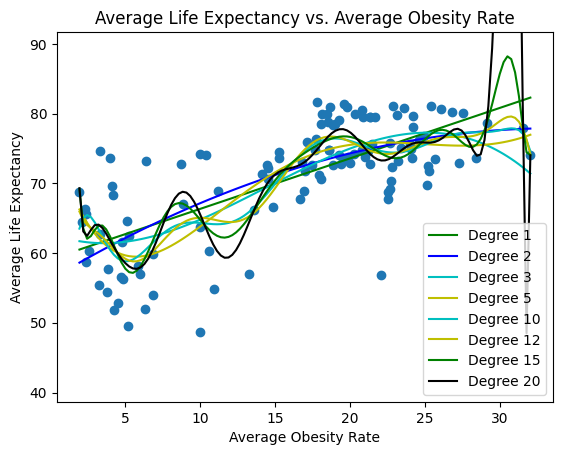

In [3]:
# Create a new datafram in which we store the average of all keys, per country, keeping the country as key
df_mean = data.groupby('Country').mean()

# X = average obesity per country, y = average life expectancy per country.
x = df_mean['Obesity among adults']
y = df_mean['Life Expectancy']


# Make a scatter plot of the average life expectancy vs. the average obesity rate
plt.scatter(x, y)
plt.ylabel('Average Life Expectancy')
plt.xlabel('Average Obesity Rate')
plt.title('Average Life Expectancy vs. Average Obesity Rate')


# Fit models with various polynomial degrees
fits_per_poly_degree = {}

x_multi_fit = np.linspace(x.min(), x.max(), len(y))
degrees = [1, 2, 3, 5, 10, 12, 15, 20]

for degree in degrees:
    coefs = np.polyfit(x, y, degree)
    fits_per_poly_degree[degree] = np.polyval(coefs, x_multi_fit)
    
# Plotting all fitted degrees over the averaged datapoints
for degree in degrees:
    plt.plot(x_multi_fit, 
             fits_per_poly_degree[degree], 
             COLORS[degree % len(COLORS)], 
             label = 'Degree ' + str(degree))

plt.ylim(min(y) - 10, max(y) + 10)
plt.legend()
plt.show()

plt.show()

### Estimating the prediction error

Assume target data $z$ (actual LE values) is distributed according to a Gaussian\
The likelihood of the data can be written as:

$$ \mathcal{L} = \prod_i \frac{1}{Z}\text{exp} \frac{-(f(x_i) - z_i)^2}{2\sigma^2}  $$

where Z is the normalization constant we do not care about (for now). We set it to 1.

In [4]:

# Formula for calculating Likelihood of a Gaussian distribution
def gaus_likelihood(data, prediction):
    Z = 1
    stddev = np.std(data)
    values = []
    
    for i in range(len(data)):
        values.append(
        1 / Z *
        np.e ** (
                (-(prediction[i] - data[i])**2) 
                 / (2 * stddev **2)
                )
        )
        
    return np.prod(values)


Akaike score:

$$ \text{AIC} = 2k - 2\text{ln}(\hat{L}) $$

Where k is the amount of parameters of the model, and L is the maximized Likelihood of the model.

In [5]:
def akaike_score(n_params, likelihood_score):
    return (2 * n_params) - (2 * np.log(likelihood_score))

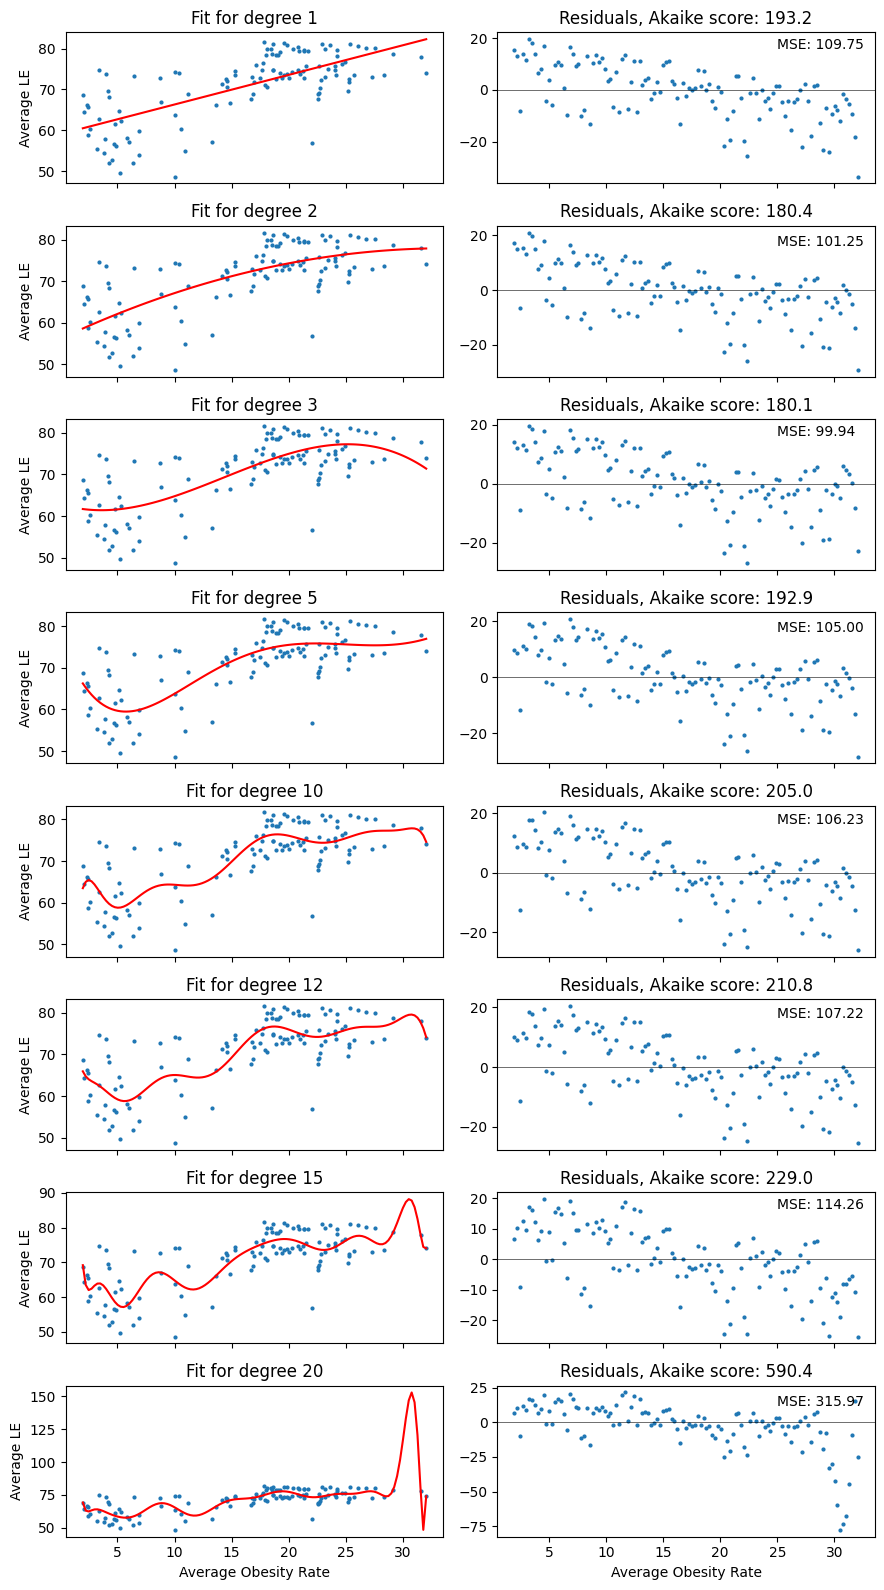

In [6]:
# Divide plot into plots per degree
fig, axs = plt.subplots(len(degrees), 2, figsize = (9, len(degrees)*2), sharex = True)


# Plot single degree fits over the averaged datapoints, and plot their accompanying residuals on the side
for i, degree in enumerate(fits_per_poly_degree.keys()):
    y_single_degree = fits_per_poly_degree[degree]
    
    axs[i, 0].plot(x_multi_fit, y_single_degree, color = 'r')
    axs[i, 0].scatter(x, y, s = 4)
    axs[i, 0].set_title("Fit for degree " + str(degree))
    axs[i, 0].set(ylabel = "Average LE")
    # Set x label for bottom plots
    if i == len(fits_per_poly_degree) - 1:
        axs[i, 0].set(xlabel = "Average Obesity Rate")
        axs[i, 1].set(xlabel = "Average Obesity Rate")
    
    # Plotting the residuals...
    y_residuals = [y[i] - y_single_degree[i] for i in range(len(y))]

    
    axs[i, 1].scatter(x_multi_fit, y_residuals, s = 4)
    axs[i, 1].axhline(0,color="black", linewidth = 0.4)
    
    # Calculating MSE of model from residuals and adding to plot
    mse = np.mean([value ** 2 for value in y_residuals])
    axs[i, 1].text(25, 20, s=f'MSE: {mse:.2f}', ha='left', va='top') 

    # Calculate likelihood of fit scores and akaike score of amount of parameters (which is equal to the degree
    # of the fit).
    likelihood = gaus_likelihood(y, y_single_degree)
    akaike = akaike_score(degree, likelihood)
    axs[i, 1].set_title("Residuals, Akaike score: " + str(round(akaike, 1)))
    
fig.tight_layout()
# plt.xscale('log')
plt.show()

In each of the residuals plots there is a slight downwards trend visible, especially as the degrees get very high (20). The datapoints do not seem to be spread randomly, so we can conclude that the regression models are not enough by themselves to establish a correlation. What is happening between obesity rate and life expectancy is more complex and possibly dependent on other variables as well.

## Find clusters in average obesity vs life expectancy data per country

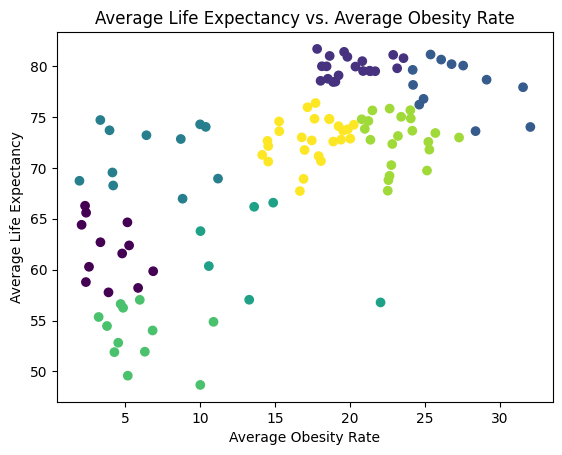

Cluster 0, 12 countries
Cluster 1, 20 countries
Cluster 2, 12 countries
Cluster 3, 11 countries
Cluster 4, 6 countries
Cluster 5, 12 countries
Cluster 6, 21 countries
Cluster 7, 25 countries


In [7]:
# Reshape x and y into a 2D array
X = np.array([x, y]).T

# Create a KMeans object with n clusters
amount_of_clusters = 8
kmeans = KMeans(n_clusters=amount_of_clusters, n_init=100)

# Fit the data to the KMeans object
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.predict(X)

# Plot the clusters
plt.scatter(x, y, c=labels)
plt.ylabel('Average Life Expectancy')
plt.xlabel('Average Obesity Rate')
plt.title('Average Life Expectancy vs. Average Obesity Rate')
plt.show()

# Make x and y into 2d lists per cluster
x_clustered = [[] for _ in range(len(set(labels)))]
y_clustered = [[] for _ in range(len(set(labels)))]

# Add all missing data to the clustered lists
# Simply put, reconstruct the original data, but now per cluster instead of one big list
for i in range(len(x)):
    avg_data = df_mean.iloc[i]
    x_clustered[labels[i]].append((x[i], avg_data))
    y_clustered[labels[i]].append(y[i])

for i in range(len(x_clustered)):
    print(f'Cluster {i}, {len(x_clustered[i])} countries')
    

In [8]:
# Make the above list of list of tuples into a list of dataframes
columns = x_clustered[0][0][1].keys()
dfs = [pd.DataFrame(columns=columns) for _ in range(len(x_clustered))]
for i, list in enumerate(x_clustered):
    for list2 in list:
        dfs[i] = dfs[i].append(list2[1], ignore_index=True)

# Create a LinearRegression object per cluster
regs = [LinearRegression() for _ in range(len(x_clustered))]
scores = []

# Create an empty dataframe to store the coefficients, but drop the Life Expectancy column
columns = df_mean.drop(['Life Expectancy', 'Year'], axis=1).keys()
coef_df = pd.DataFrame(columns=columns)

# Fit the data to the LinearRegression object
for df, reg in zip(dfs, regs):
    X = df.drop(['Life Expectancy', 'Year'], axis=1)
    Y = df["Life Expectancy"]

    # Fit the data to the LinearRegression object
    reg.fit(X, Y)

    scores.append(reg.score(X, Y))

    # Add the coefficients to the dataframe, but ignore the column names
    coef_df = coef_df.append(pd.Series(reg.coef_, index=columns), ignore_index=True)

print(coef_df)
# Store this dataframe in a csv file
coef_df.to_csv('coef_df.csv')

     Population  CO2 emissions  Health expenditure  \
0 -7.404341e-09       0.555903           -1.061540   
1  4.127122e-09      -0.312971            0.006518   
2  3.787936e-08       0.637668           -1.389057   
3  5.046791e-09      -0.129037           -0.345598   
4 -2.515791e-07       0.054629           -0.042968   
5 -2.255049e-07      12.451616           -6.696199   
6 -1.242000e-09      -0.477927            0.537374   
7 -1.165480e-08      -0.221621           -0.203012   

   Electric power consumption  Forest area  GDP per capita  \
0                    0.013131     0.091861        0.001167   
1                   -0.000133     0.018667        0.000118   
2                   -0.000983     0.076827       -0.000240   
3                   -0.003302     0.128129        0.000307   
4                    0.004212     0.137682       -0.002219   
5                   -0.002497    -0.843320       -0.000444   
6                    0.000051    -0.035569        0.000274   
7                

In [9]:
countries_per_cluster = {}

for i in range(len(regs)):
    cluster = x_clustered[i]
    names = [country[1].name for country in cluster]

    countries_per_cluster[i] = names

print(countries_per_cluster)

def get_cluster(country):
    for i in range(len(countries_per_cluster)):
        if country in countries_per_cluster[i]:
            return i

    return None

{0: ['Benin', 'Cambodia', 'Eritrea', 'Ethiopia', 'Ghana', 'India', 'Kenya', 'Myanmar', 'Nepal', 'Pakistan', 'Senegal', 'Sudan'], 1: ['Austria', 'Belgium', 'Costa Rica', 'Cyprus', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Israel', 'Italy', 'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Slovenia', 'Spain', 'Sweden', 'Switzerland'], 2: ['Australia', 'Canada', 'Chile', 'Czechia', 'Kuwait', 'Malta', 'New Zealand', 'Qatar', 'Saudi Arabia', 'United Kingdom', 'United States', 'Uruguay'], 3: ['Bangladesh', 'Brunei Darussalam', 'China', 'Indonesia', 'Kyrgyz Republic', 'Malaysia', 'Mauritius', 'Philippines', 'Sri Lanka', 'Tajikistan', 'Thailand'], 4: ['Bolivia', 'Botswana', 'Gabon', 'Mongolia', 'South Africa', 'Yemen'], 5: ['Angola', 'Cameroon', 'Congo Dem. Rep.', 'Congo Rep.', "Cote d'Ivoire", 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Tanzania', 'Togo', 'Zimbabwe'], 6: ['Argentina', 'Bahrain', 'Belarus', 'Bulgaria', 'Croatia', 'Egypt', 'Estonia', 'Hungary', 'Iraq'

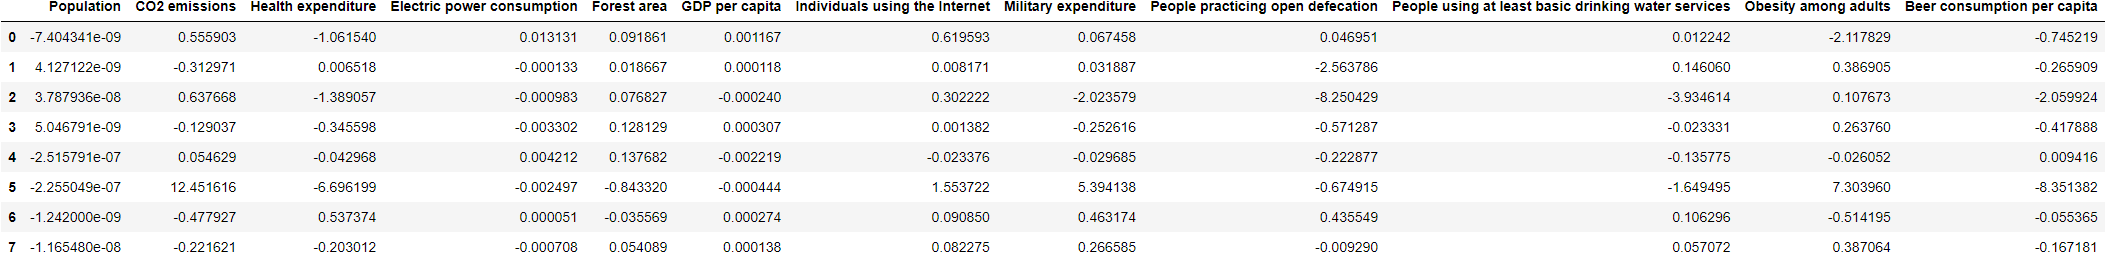

In [10]:

try:
    import dataframe_image as dfi
    dfi.export(coef_df, 'coef_df.png')
except Exception:
   print("Failed to generate new image, showing old image")
except RuntimeError:
   print("Failed to generate new image, showing old image")

from IPython.display import Image
Image(filename = 'coef_df.png')

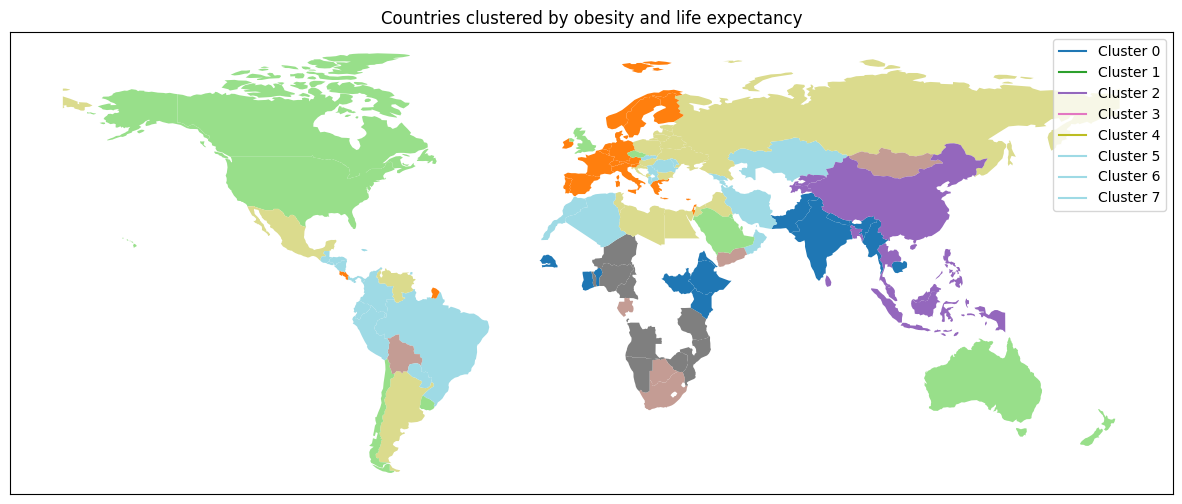

In [11]:
# Read the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Remove Antarctica
world = world[world.name != 'Antarctica']

# Make an empty dataframe
df_map = pd.DataFrame(columns=['name', 'cluster'])
countries_converted = []
clusters = []

# Rename countries to match the world map
for country in COUNTRIES:
    if country == 'Congo Dem. Rep':
        countries_converted.append('Dem. Rep. Congo')
        clusters.append(get_cluster('Congo Dem. Rep'))
    elif country == 'Czech Republic':
        countries_converted.append('Czechia')
        clusters.append(get_cluster('Czech Republic'))
    elif country == 'Egypt, Arab Rep.':
        countries_converted.append('Egypt')
        clusters.append(get_cluster('Egypt, Arab Rep.'))
    elif country == 'Sudan':
        countries_converted.append('S. Sudan')
        clusters.append(get_cluster('Sudan'))
    elif country == 'Gambia, The':
        countries_converted.append('Gambia')
        clusters.append(get_cluster('Gambia, The'))
    elif country == 'Iran, Islamic Rep.':
        countries_converted.append('Iran')
        clusters.append(get_cluster('Iran, Islamic Rep.'))
    elif country == 'Kyrgyz Republic':
        countries_converted.append('Kyrgyzstan')
        clusters.append(get_cluster('Kyrgyz Republic'))
    elif country == 'Russian Federation':
        countries_converted.append('Russia')
        clusters.append(get_cluster('Russian Federation'))
    elif country == 'Slovak Republic':
        countries_converted.append('Slovakia')
        clusters.append(get_cluster('Slovak Republic'))
    elif country == 'Syrian Arab Republic':
        countries_converted.append('Syria')
        clusters.append(get_cluster('Syrian Arab Republic'))
    elif country == 'United States':
        countries_converted.append('United States of America')
        clusters.append(get_cluster('United States'))
    else:
        countries_converted.append(country)
        clusters.append(get_cluster(country))

# Remove countries that are not in the dataset
world = world[world.name.isin(countries_converted)]

# Add the countries and clusters to the dataframe of the world map
df_map['name'] = countries_converted
df_map['cluster'] = clusters

# Merge the dataframes
world = world.merge(df_map, on='name')

# Plot the map, with the colors corresponding to the clusters, per cluster
map = world.plot(column='cluster', cmap='tab20', figsize=(15, 12))

# Create a legend using empty scatterplots
for i in range(len(regs)):
    color = matplotlib.cm.get_cmap('tab20')(i * 4)
    plt.plot([], [], color=color, label=f'Cluster {i}')

plt.title("Countries clustered by obesity and life expectancy")
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.legend()
plt.show()

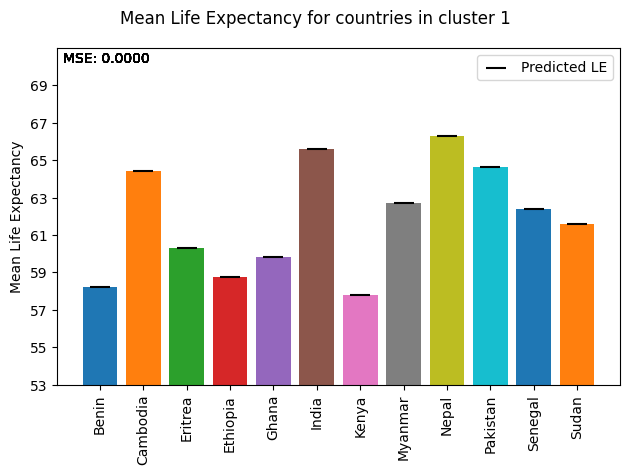

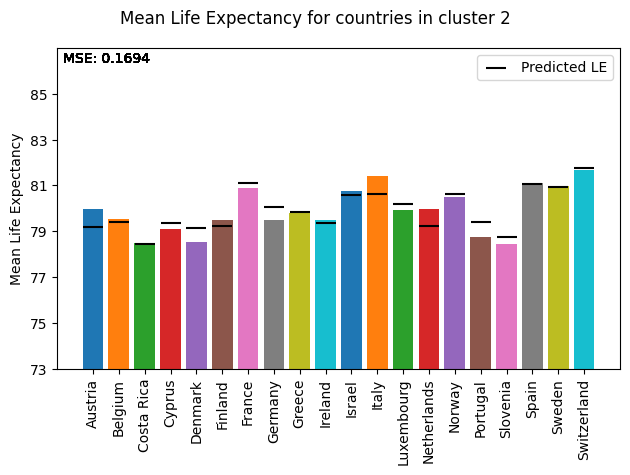

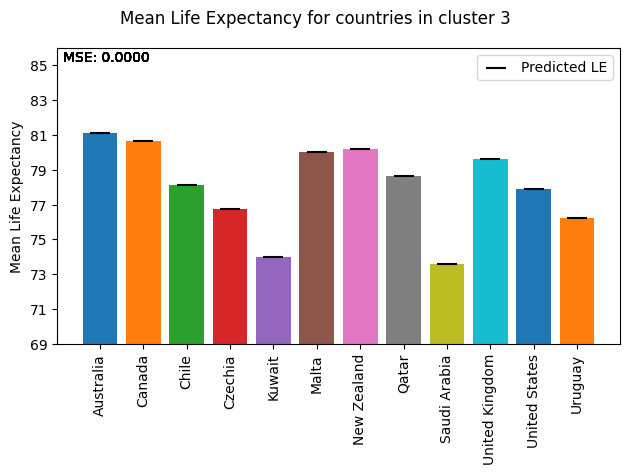

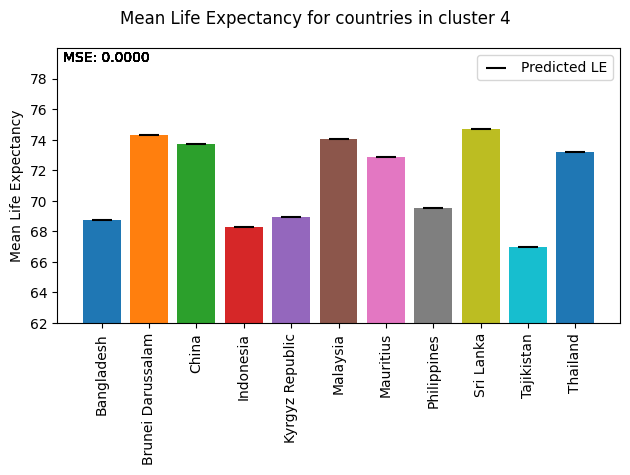

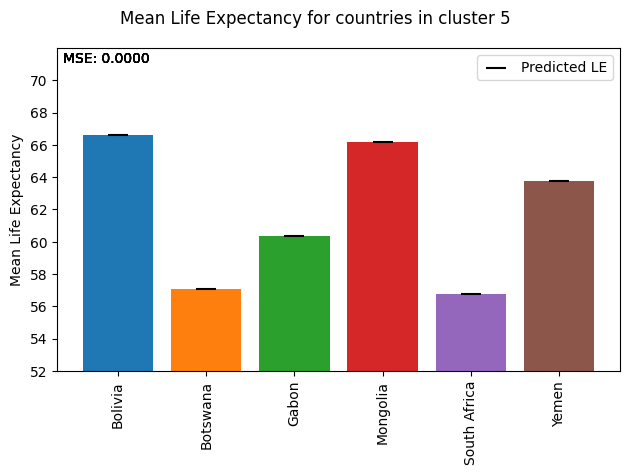

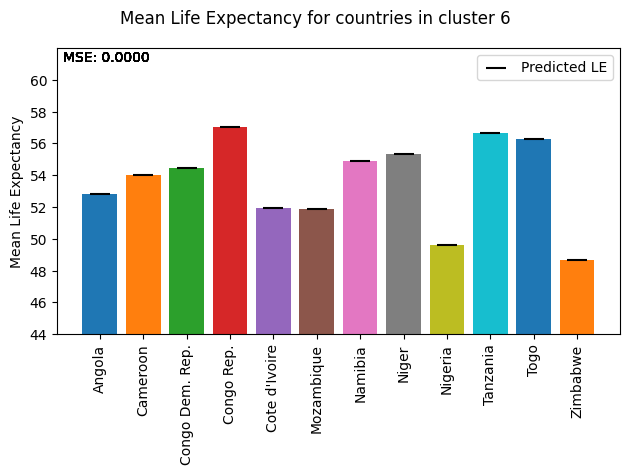

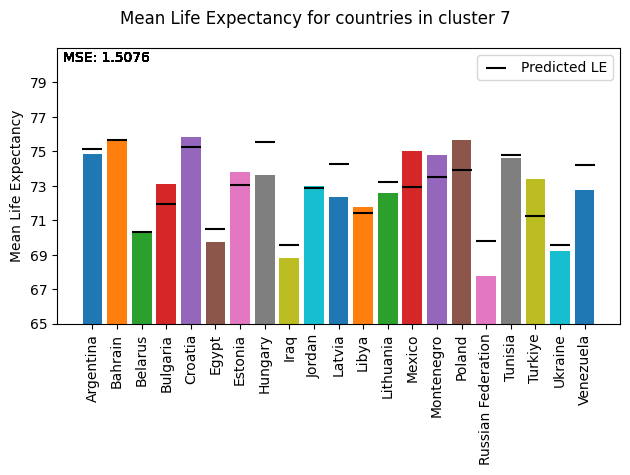

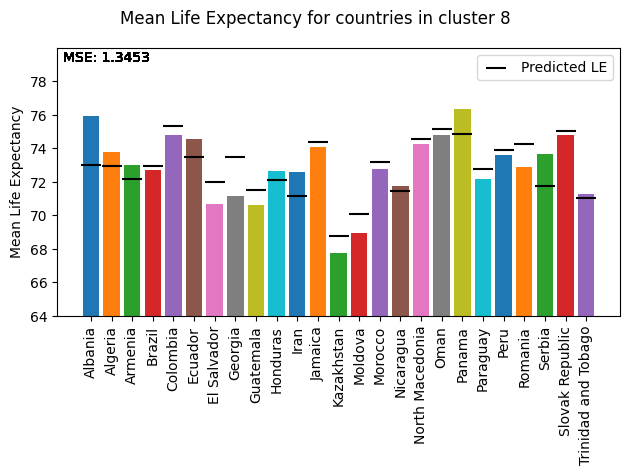

In [12]:
from sklearn.metrics import mean_squared_error
# inintialize list to plot later
data_to_plot = []

# add to the list the countries and its LE per cluster
for i, cluster in enumerate(x_clustered):
    data_to_plot.append([])

    for country in cluster:
        data_to_plot[i].append([country[1].name, country[1][1]])


# add to the list the predicted LE in that cluster
for i, reg in enumerate(regs):
    new_x = np.array(dfs[i].drop(['Life Expectancy', 'Year'], axis=1))
    new_y = reg.predict(new_x)
    data_to_plot[i].append(new_y)


# plot the data
for i, cluster in enumerate(data_to_plot):
    predicted_le = cluster[-1]

    # Calcualte the mean squared error (MSE) per cluster
    true_le = [country[1] for country in cluster[0:-1]]
    mse = mean_squared_error(true_le, predicted_le)

    # Plot bar graphs per country and its mean LE
    f, ax = plt.subplots()
    for country in cluster[0:-1]:
        plt.bar(country[0], country[1])
        plt.text(.01, .99, s=f'MSE: {mse:.4f}', ha='left', va='top', transform=ax.transAxes)
        plt.ylabel('Mean Life Expectancy')
        plt.suptitle(f'Mean Life Expectancy for countries in cluster {i+1}')
        plt.xticks(rotation = 90)
        plt.yticks([round(x) for x in range(round(min(predicted_le) - 5), round(max(predicted_le) + 5), 2)])

    # Plot the predicted LE
    x = range(len(predicted_le)) 
    plt.scatter(x, predicted_le, marker='_', s=200, label='Predicted LE', color='black')
    plt.ylim(round(min(predicted_le) - 5), round(max(predicted_le) + 5))

    plt.legend(loc=0)
    f.tight_layout()
    plt.show()

### Taking another look at the residuals of the data per cluster

In [13]:
# Splitting the data
predictions = np.array([data[-1] for data in data_to_plot])
 
real_data_per_country = [cluster[0:-1] for cluster in data_to_plot]

real_data = np.array([[pair[1] for pair in cluster] for cluster in real_data_per_country])


In [14]:

for i in range(amount_of_clusters):
    residuals = real_data[i] - predictions[i]
    print(residuals)

[ 7.46069873e-13  7.53175300e-13  8.24229573e-13  1.42108547e-13
  6.96331881e-13 -6.05382411e-12  5.96855898e-13  5.11590770e-13
  6.11066753e-13 -1.42108547e-13  7.60280727e-13  6.03961325e-13]
[ 0.79814284  0.13176954  0.02085015 -0.26336751 -0.60659661  0.25165062
 -0.1856863  -0.55913331 -0.03938719  0.15242248  0.18410076  0.76616069
 -0.25878365  0.7542144  -0.15668302 -0.67330658 -0.33406842  0.03277018
  0.07340124 -0.08847031]
[ 1.05160325e-12  5.78381787e-12 -3.92219590e-12 -2.54374299e-12
  7.36122274e-12 -2.78532752e-12  1.09423581e-12  4.16378043e-12
 -1.63424829e-12 -3.32534000e-12  6.53699317e-13 -6.02540240e-12]
[-8.52651283e-14  1.10844667e-12 -4.95958830e-12 -3.97903932e-13
  1.57740487e-12  6.25277607e-13  7.81597009e-13  8.52651283e-14
  3.55271368e-13  5.96855898e-13  2.98427949e-13]
[-5.68434189e-14  7.10542736e-14 -2.84217094e-14  2.84217094e-14
  2.13162821e-14 -7.10542736e-14]
[ 2.28865815e-11  5.96855898e-12 -4.02735623e-11  3.37507799e-11
  1.38271616e-11  2